# Kaggle Competition - I'm Something of a Painter Myself

In [5]:
#General libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os
import time


#deep learning
import tensorflow as tf
import keras
import torch.nn as nn
from PIL import Image
import shutil
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import glob
from tensorflow.keras import layers, Model


from collections import Counter
from sklearn.cluster import KMeans
from tqdm import tqdm
import PIL


E0000 00:00:1753456936.860217      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
#use tpu resources from kaggle
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    print("TPU initialized")
except Exception as e:
    strategy = tf.distribute.get_strategy()  # fallback to CPU/GPU
    BATCH_SIZE = 1
    print("TPU not found, using default")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753457186.824632      10 service.cc:148] XLA service 0x5a136a773b20 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753457186.824694      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753457186.824699      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753457186.824702      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753457186.824707      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753457186.824709      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753457186.824712      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753457186.824723      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753457186.824725      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

## Introduction and Data Read-In

The goal of this challenge is to use a Generative Adversarial Network (GAN) to create images of Monet paintings that are similar - but not identical - to the original pictures. GANs consist of two neural networks: Generators and Discriminators, which create the fake data and tries to discriminate between real and fake data, respectively. This is referred to as an "adversarial" process, as these two processes have opposite objectives. 

To start, we can read in a dataset containing of Monet paintings and one consisting of pictures (that are not Monet paintings).

In [ ]:
#data path read-in to kaggle
monet_tf_path = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
photo_tf_path = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'

monet_tf = tf.data.Dataset.list_files(monet_tf_path)
photo_tf = tf.data.Dataset.list_files(photo_tf_path)

print('Monet TFRecord Files: ', len(monet_tf))
print('Photo TFRecord Files: ', len(photo_tf))

Monet TFRecord Files:  5
Photo TFRecord Files:  20


Next, we can take a look at some of the images in the dataset. At this time, we can also set some variables to be used for training later. 

In [13]:
img_size = [256, 256]

#create a class to preprocess images - used for our tfrec files. 
class ImagePreprocessor:
    def __init__(self, training=True):
        self.training = training

    def decode(self, image):
        img = tf.image.decode_jpeg(image, channels=3)
        return img

    def read_tfrecord(self, tfrecord):
        format_tf = {
            'image_name': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string),
            'target': tf.io.FixedLenFeature([], tf.string),
        }
        ex = tf.io.parse_single_example(tfrecord, format_tf)
        image = self.decode(ex['image'])
        return image

    def random_crop(self, image):
        return tf.image.random_crop(image, size=[img_size[0], img_size[1], 3])

    def normalize(self, image):
        image = tf.cast(image, tf.float32)
        return (image / 127.5) - 1

    def random_jitter(self, image):
        image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        image = self.random_crop(image)
        image = tf.image.random_flip_left_right(image)
        return image

    def preprocess_image_train(self, image):
        image = self.random_jitter(image)
        return self.normalize(image)

    def preprocess_image_test(self, image):
        return self.normalize(image)

    def preprocess_image(self, tfrecord):
        image = self.read_tfrecord(tfrecord)
        if self.training:
            return self.preprocess_image_train(image)
        else:
            return self.preprocess_image_test(image)

    def load_dataset(self, tf_files, batch_size=BATCH_SIZE, repeat=True):
        dataset = tf.data.TFRecordDataset(tf_files)
        dataset = dataset.map(lambda x: self.preprocess_image(x), num_parallel_calls=AUTOTUNE)
        if repeat:
            dataset = dataset.repeat()
        dataset = dataset.shuffle(1024)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(AUTOTUNE)
        return dataset

In [14]:
#train/test variables
train_preprocessor = ImagePreprocessor(training=True)
test_preprocessor = ImagePreprocessor(training=False)

monet_ds = train_preprocessor.load_dataset(monet_tf)
photo_ds = train_preprocessor.load_dataset(photo_tf)
test_monet_ds = test_preprocessor.load_dataset(monet_tf, batch_size=1, repeat=False)
test_photo_ds = test_preprocessor.load_dataset(photo_tf, batch_size=1, repeat=False)

In [15]:
print("Monet Images: ", sum(1 for _ in tf.data.TFRecordDataset(monet_tf)))
print('Photo Images: ', sum(1 for _ in tf.data.TFRecordDataset(photo_tf)))

Monet Images:  300
Photo Images:  7038


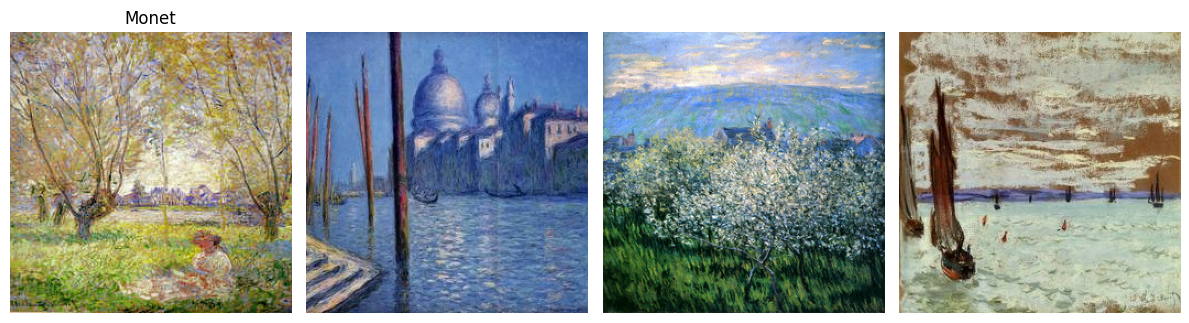

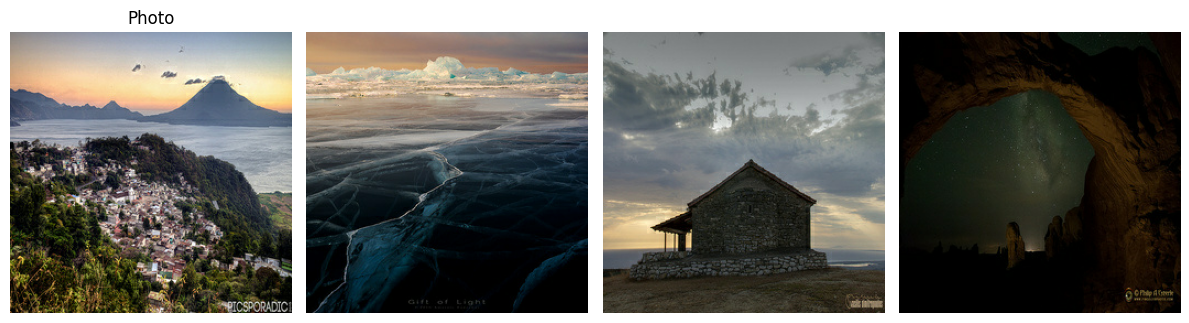

In [ ]:
#function to display images - some monet, some photo
def display_img(ds, title):
    plt.figure(figsize=(12,6))
    for i, img in enumerate(ds.take(4)):
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title) if i == 0 else ''
    plt.tight_layout()
    plt.show()

display_img(test_monet_ds, 'Monet')
display_img(test_photo_ds, 'Photo')

## Model Building and Tuning

The generator and discriminator models will be created for the GAN. Additionally, loss functions will be outlined. 

For the purpose of this challenge, the metric of choice is MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).



In [17]:
OUTPUT_CHANNELS = 3 #RGB

#create generator
class Generator:
        #create a downsample function
    def downsample(self, filters, size, apply_instancenorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))
    
        if apply_instancenorm:
            result.add(layers.GroupNormalization(1)) 
    
        result.add(layers.LeakyReLU())
    
        return result
        #create an upsample function
    def upsample(self, filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(layers.GroupNormalization(1)) # instance normalization 
    
        if apply_dropout:
            result.add(layers.Dropout(0.5))
    
        result.add(layers.ReLU())
    
        return result

    def build(self):
        inputs = layers.Input(shape=[img_size[0], img_size[1], 3])

        # bs = batch size
        down_stack = [
            self.downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
            self.downsample(128, 4), # (bs, 64, 64, 128)
            self.downsample(256, 4), # (bs, 32, 32, 256)
            self.downsample(512, 4), # (bs, 16, 16, 512)
            self.downsample(512, 4), # (bs, 8, 8, 512)
            self.downsample(512, 4), # (bs, 4, 4, 512)
            self.downsample(512, 4), # (bs, 2, 2, 512)
            self.downsample(512, 4), # (bs, 1, 1, 512)
        ]
    
        up_stack = [
            self.upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
            self.upsample(512, 4), # (bs, 16, 16, 1024)
            self.upsample(256, 4), # (bs, 32, 32, 512)
            self.upsample(128, 4), # (bs, 64, 64, 256)
            self.upsample(64, 4), # (bs, 128, 128, 128)
        ]
        #for initialization of the model
        initializer = tf.random_normal_initializer(0., 0.02)
        last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh') # (bs, 256, 256, 3)
    
        x = inputs
    
        
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)
    
        skips = reversed(skips[:-1])
    
        
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = layers.Concatenate()([x, skip])
    
        x = last(x)
    
        return keras.Model(inputs=inputs, outputs=x, name='generator')

In [18]:
#create the discriminator function
class Discriminator:

    def downsample(self, filters, size, apply_instancenorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))
    
        if apply_instancenorm:
            result.add(layers.GroupNormalization(1)) 
    
        result.add(layers.LeakyReLU())
    
        return result

    def build(self):    
        inp = layers.Input(shape=[img_size[0], img_size[1], 3], name='input_image')
        x = inp
    
        ds_stack = [
            self.downsample(64, 4, apply_instancenorm=False), # batch, 128, 128, 64
            self.downsample(128, 4), # batch, 64, 64, 128
            self.downsample(256, 4), # batch, 32, 32, 256
        ]
    
        for ds in ds_stack:
            x = ds(x)
        
        result = keras.Sequential([
            layers.Conv2D(512, 4, strides=1, padding='same'), # batch, 32, 32, 512
            layers.GroupNormalization(1), 
            layers.LeakyReLU(),
            layers.Conv2D(1, 4, strides=1, padding='same'), #patch map
        ])
    
        x = result(x)
    
        return tf.keras.Model(inputs=inp, outputs=x, name='discriminator')

In [19]:
with strategy.scope():
    monet_generator = Generator().build()
    photo_generator = Generator().build()

    monet_discriminator = Discriminator().build()
    photo_discriminator = Discriminator().build()

I0000 00:00:1753457196.396715      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [20]:
monet_generator.summary() #generator summary


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,328 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    524,800 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,098,176 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,195,328 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,195,328 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,195,328 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,195,328 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,389,632 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,389,632 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,389,632 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
monet_discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_33 (Sequential)      │ (None, 32, 32, 1)      │     2,106,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,081 (10.55 MB)

 Trainable params: 2,766,081 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#create our gan model
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            #photo > monet > photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            #monet > photo > monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            #discriminator - real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            #discriminator - fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            #loss function input
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            #cycle loss
            total_cycle_loss = (
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + 
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            )

            #generator loss
            total_monet_gen_loss = (
                monet_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            )
            total_photo_gen_loss = (
                photo_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            )

            #discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        #gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        #optimizer 
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

    def call(self, inputs, training=False):
        return self.m_gen(inputs, training=training)

In [23]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [24]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan_model = CycleGan(
        monet_generator, 
        photo_generator, 
        monet_discriminator, 
        photo_discriminator
    )
    
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [25]:
#run the model!
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50,
    steps_per_epoch= 200
)

Epoch 1/50


I0000 00:00:1753457275.530499      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5698036721990912170
I0000 00:00:1753457281.822302    1033 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1844616456027889758), session_name()
I0000 00:00:1753457339.907564    1033 tpu_compile_op_common.cc:245] Compilation of 1844616456027889758 with session name  took 58.085222027s and succeeded
I0000 00:00:1753457340.090876    1033 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1844616456027889758), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_5698036721990912170", property.function_library_fingerprint = 17006748183751621651, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z

200/200 ━━━━━━━━━━━━━━━━━━━━ 180s 265ms/step - monet_disc_loss: 0.6980 - monet_gen_loss: 5.4132 - photo_disc_loss: 0.6761 - photo_gen_loss: 5.5682
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - monet_disc_loss: 0.6309 - monet_gen_loss: 3.6501 - photo_disc_loss: 0.6433 - photo_gen_loss: 3.6494
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - monet_disc_loss: 0.6320 - monet_gen_loss: 3.2885 - photo_disc_loss: 0.6432 - photo_gen_loss: 3.2879
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 3.0834 - photo_disc_loss: 0.6318 - photo_gen_loss: 3.1043
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8861 - photo_disc_loss: 0.6317 - photo_gen_loss: 2.9462
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.7524 - photo_disc_loss: 0.6306 - photo_gen_loss: 2.8291
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 263ms/step - monet_disc_

Now that the model has been run, we can take a look at the outputs.

In [26]:
history

## Results and Analysis

Now that the model has been generated, we can take a look at some of the outputs, as well as data related to the performance of the models. 

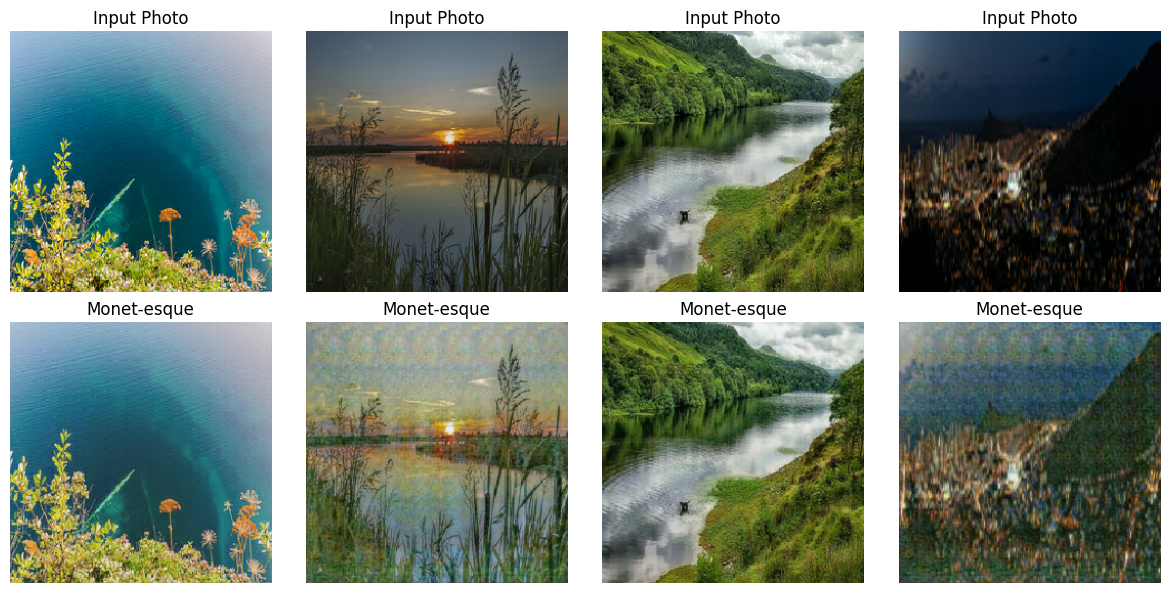

In [27]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, img in enumerate(photo_ds.take(4)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()

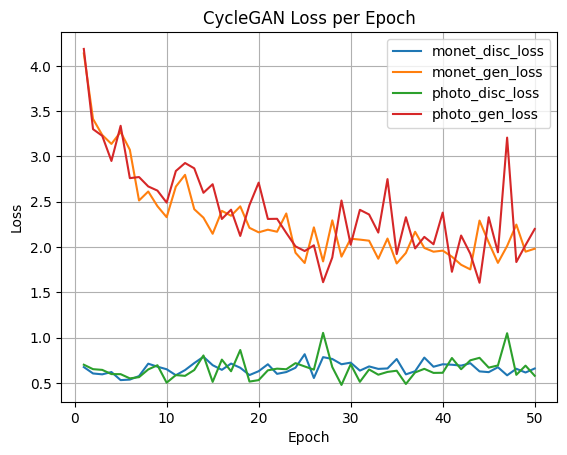

In [ ]:
for name, losses in history.history.items():
    #display loss values for monet and photos. 
    scalar_losses = [tf.reduce_mean(l).numpy() for l in losses]
    plt.plot(range(1, len(scalar_losses)+1), scalar_losses, label=name)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CycleGAN Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Finally, we will write our output to file. 

In [ ]:
! mkdir ../images #create a directory in kaggle


In [ ]:
for i, img in enumerate(tqdm(test_photo_ds, total=7001), 1):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")

7038it [33:07,  3.54it/s]                          


In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images") #save zip file to kaggle

'/kaggle/working/images.zip'

## Conclusion

The final model received a test MiFID score of **59.24620**. This is a clear sign that GANs can effectively generate and discriminate pictures of Monet paintings.

This can be a very generalized task for visual media, as a GAN can generate outputs with similar features to the original media, and it can discriminate the differences between real and fake images. There are use cases in video game creation, art, music production, and authenticity detection. 

In terms of future directions, more attention to hyperparameter tuning, or perhaps creating a model with transferable properties to other types of media might be of interest. However, as it stands, GANs can be a useful tool for photo generation and discrimination. 